## Intro

This notebook runs the negative correlation algorithm for squared loss through pytorch, and measure the diversity

In [3]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')

from decompose import CrossEntropy
import bvdlib

import torch
import torch.nn as nn
import torch.nn.functional as F

import ml_utils
from ml_utils.torch_data_utils import minimal_implementation_dataset
from ml_utils.ensemble_utils import ImageWOOF_SimpleConvnet
from ml_utils.ensemble_utils import Ensemble_Runner
from ml_utils.ensemble_utils import torch_MCCE_logit_combiner

from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from fastai.data.external import untar_data
from fastai.data.external import URLs

In [3]:



# mock_member_logit_output = torch.rand((11, 3, 10))
# ens_logit_output = torch.mean(mock_member_logit_output, dim=0)
# member_prob_output = torch.functional.F.softmax(mock_member_logit_output, dim=-1)

# target = torch.empty(3, dtype=torch.long).random_(5)


# ens_norm_mean = norm_geo_mean(member_prob_output)
# ens_soft_out = torch.functional.F.softmax(ens_logit_output, dim=-1)

# print(nn.CrossEntropyLoss()(ens_logit_output, target))
# print(nn.NLLLoss()(torch.log(ens_norm_mean), target))

# diff = ens_soft_out - ens_norm_mean #allclose is 0

In [4]:
# mock_member_logit_output = torch.rand((11, 3, 10))
# ens_logit_output = torch.mean(mock_member_logit_output, dim=0)
# member_prob_output = torch.functional.F.softmax(mock_member_logit_output, dim=-1)

# target = torch.empty(3, dtype=torch.long).random_(5)


# ens_norm_mean = norm_geo_mean(member_prob_output)
# ens_soft_out = torch.functional.F.softmax(ens_logit_output, dim=-1)

# print(nn.CrossEntropyLoss()(ens_logit_output, target))
# print(nn.NLLLoss()(torch.log(ens_norm_mean), target))

# diff = ens_soft_out - ens_norm_mean #allclose is 0


In [5]:
save_path_without_extension = project_directory + "experiments/results/MCCE_NCL_ImageWOOF"

## Pre-Process Data

In [6]:
# get data

data_path = untar_data(URLs.IMAGEWOOF_160)


smallest_training_resolution = 160 # its a square
imagenet_transform_mean = np.mean([0.485, 0.456, 0.406])
imagenet_transform_std = np.mean([0.229, 0.224, 0.225])

transformation = transforms.Compose([
    
    transforms.ToPILImage(),
    transforms.CenterCrop(smallest_training_resolution),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_transform_mean,std=imagenet_transform_std),
    
])  


training_data = datasets.DatasetFolder(
    root = data_path / 'train',
    loader = lambda x: torchvision.io.read_image(x),
    extensions = ('.jpg', '.jpeg', '.png'),
    transform = transformation
)

testing_data = datasets.DatasetFolder(
    root = data_path / 'val',
    loader = lambda x: torchvision.io.read_image(x),
    extensions = ('.jpg', '.jpeg', '.png'),
    transform = transformation
)



In [7]:
train_data = []
for i, img in enumerate(training_data):
    x, y = img
    train_data.append(x)
train_data = np.expand_dims(np.array(train_data).squeeze(), axis=1) # sorry!
train_labels = np.array(training_data.targets)

test_data = []
for i, img in enumerate(testing_data):
    x, y = img
    test_data.append(x)
test_data = np.expand_dims(np.array(test_data).squeeze(), axis=1)# sorry!
test_labels = np.array(testing_data.targets)

In [8]:
print("Training shapes", train_data.shape, train_labels.shape)
print("Testing shapes", test_data.shape, test_labels.shape)

Training shapes (9025, 1, 160, 160) (9025,)
Testing shapes (3929, 1, 160, 160) (3929,)


In [9]:
# # used in getting minimum training data resolutons
# min1=200
# min2=200
# for i, (dat, y) in enumerate(training_data):
#     imgs = dat.size()
#     res1=imgs[1]
#     res2=imgs[2]
#     if res1 < min1:
#         min1=res1
#     if res2 < min2:
#         min2=res2 
# print(min1, min2)

In [52]:
decomp_fn = CrossEntropy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = torch.nn.CrossEntropyLoss()
test_dset = minimal_implementation_dataset(test_data, test_labels, device)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size = len(test_dset) // 30, shuffle=False)
chosen_model = ImageWOOF_SimpleConvnet
combiner_rule = torch_MCCE_logit_combiner

parameter_dictionary = {
    "epoch_n": 4,
    "estimator_n": 5,
    "batch_size" : 128,
    # "hidden_size" : 24,
    # "hidden_layer_num" : 2,
    "device" : device,
    "combiner_rule" : combiner_rule,
    "criterion" : criterion,
}


In [11]:
n_trials = 7
data_percentage_training = len(train_labels)
num_training =  int(0.8 * data_percentage_training) # percent of data for each trial from training
trial_space = np.arange(0,7, 0.5) / 10
experiment_seed = 0
torch_generator = torch.manual_seed(experiment_seed)

consider_epoch_every_x_steps = 5

In [12]:
imagewoof_classes = 10

## Run Experiments

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.func import stack_module_state
from torch import vmap
from torch.func import functional_call
import copy

class Ensemble_Runner():
    def __init__(self, exmaple_model, combiner_rule):
        self.metamodel = copy.deepcopy(exmaple_model).to('meta')
        self.combiner_rule = combiner_rule
        
    def forward_through_metamodel(self, params, buffers, x):
        return functional_call(self.metamodel, (params, buffers), (x,))
    
    def forward(self, x, ensemble):
        params, buffers = stack_module_state(nn.ModuleList(ensemble))
        
        # print(x.shape)

        # print(x.repeat(len(ensemble), 1, 1, 1, 1).shape)

        member_output = vmap(self.forward_through_metamodel)(params, buffers, x.repeat(len(ensemble), 1, 1, 1, 1))

        # print(member_output.shape)

        ensemble_output = self.combiner_rule(member_output)

        # print(ensemble_output.shape)
        return ensemble_output, member_output

In [28]:
  

#setup trial
params = parameter_dictionary
trial_estimators = params['estimator_n']
epoch_results = []
epoch_ens_train_losses = []
epoch_ens_test_losses = []
epoch_member_train_losses = []
epoch_member_test_losses = []

trial_x, trial_y = train_data, train_labels
trial_dset = minimal_implementation_dataset(trial_x, trial_y, params['device'])
trial_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = params['batch_size'], shuffle=True, generator=torch_generator)
trial_unshuffled_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = len(trial_dset), shuffle=False)

trial_criterion = params['criterion']
# init model
ensemble = []
optims = []
losses = []


for member_n in range(trial_estimators):
    ensemble.append(ImageWOOF_SimpleConvnet(torch_generator).to(params['device']))
    optims.append(torch.optim.Adam(ensemble[member_n].parameters()))
    losses.append(None)
    
ens_runner = Ensemble_Runner(ensemble[0], params['combiner_rule'])
lambda_ = 0

overall_trial_stepcount = 0


#run training
for epoch in range(params['epoch_n']):
    
    trial_results_array = np.zeros((trial_estimators, len(test_data), imagewoof_classes))

    for batch_idx, (batch_x, batch_y) in enumerate(trial_dloader):

        batch_y = torch.as_tensor(batch_y, dtype=torch.long)
        # get detached ensemble output

        # if overall_trial_stepcount % consider_epoch_every_x_steps == 0:
        
        #     # print(overall_trial_stepcount, batch_idx)
        #     member_test_losses = np.zeros((trial_estimators))
        #     member_train_losses = np.zeros((trial_estimators))
        #     with torch.no_grad():
        #         trial_x_to_runnable = torch.tensor(trial_x).type(torch.float).to(params['device'])
        #         trial_y_to_runnable = torch.tensor(trial_y).unsqueeze(dim=-1).type(torch.float).to(params['device'])
        #         test_x_to_runnable = torch.tensor(test_data).type(torch.float).to(params['device'])
        #         test_y_to_ens_runnable = torch.tensor(test_labels).unsqueeze(dim=-1).type(torch.float).to(params['device'])
        #         trial_ensemble_output, trial_member_output = ens_runner.forward(trial_x_to_runnable, ensemble)
        #         test_ensemble_output, test_member_output = ens_runner.forward(test_x_to_runnable, ensemble)
        #         epoch_ens_train_losses.append(trial_criterion(trial_ensemble_output, trial_y_to_runnable).cpu())
        #         epoch_ens_test_losses.append(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
        #         trial_results_array = np.array(test_member_output.cpu().squeeze())
        #         for i in range(trial_estimators):
        #             # print(test_y_to_ens_runnable.size())
        #             member_test_losses[i] = trial_criterion(test_member_output[i], test_y_to_ens_runnable).cpu()
        #             member_train_losses[i] = trial_criterion(trial_member_output[i], trial_y_to_runnable).cpu()

        #     epoch_results.append(np.array(trial_results_array))
        #     epoch_member_train_losses.append(np.sort(member_train_losses))
        #     epoch_member_test_losses.append(np.sort(member_test_losses))
        #     overall_trial_stepcount += 1
        
        

        with torch.no_grad():
            _, member_output = ens_runner.forward(batch_x, ensemble)
        
        # update each member
        for i, member in enumerate(ensemble):
            optims[i].zero_grad()
            member_pred = member(batch_x)
            member_grad_output = torch.cat((member_output[:i], member_pred.unsqueeze(dim=0), member_output[i+1:]))
            ens_grad_output = params['combiner_rule'](member_grad_output)
            # print(member_pred.dtype, batch_y.dtype, ens_grad_output.dtype)
            losses[i] = ((trial_criterion(member_pred, batch_y)) - ((lambda_) * trial_criterion(member_pred, ens_grad_output)))
            losses[i].backward()
            optims[i].step()
            print(losses[0])
        
        
        # epoch_results.append(np.array(trial_results_array))
        # epoch_member_train_losses.append(member_train_losses)
        # epoch_member_test_losses.append(member_test_losses)

tensor(2.3035, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3035, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3035, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3035, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3035, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.2976, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.2976, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2.2976, device='cuda:0', grad_fn=<SubBack

In [63]:
for member_n in range(trial_estimators):
    ensemble.append(ImageWOOF_SimpleConvnet(torch_generator).to(params['device']))
    optims.append(torch.optim.Adam(ensemble[member_n].parameters()))
    losses.append(None)
    
ens_runner = Ensemble_Runner(ensemble[0], params['combiner_rule'])
lambda_ = 0

overall_trial_stepcount = 0

correct = 0
total = 0
for idx, (x, y) in enumerate(test_loader):
    with torch.no_grad():
        member_outs = []
        for member in ensemble:
            member_outs.append(member(x))
        ens_out = params['combiner_rule'](torch.cat(member_outs, dim=0))
        correct += torch.sum(torch.argmax(torch.nn.functional.softmax(ens_out, dim=-1), -1) == y)
        total += len(y)
print(correct / total)


tensor(0.2021, device='cuda:0')


In [55]:
print(np.bincount(test_labels))

[409 408 418 224 401 407 401 422 429 410]


tensor(0, device='cuda:0')


tensor(0, device='cuda:0')


In [13]:
# define a trial
def trial_run(trial):
  

  #setup trial
  params = trial.get_params
  trial_estimators = params['estimator_n']
  epoch_results = []
  epoch_ens_train_losses = []
  epoch_ens_test_losses = []
  epoch_member_train_losses = []
  epoch_member_test_losses = []

  trial_x, trial_y = trial.get_data
  trial_dset = minimal_implementation_dataset(trial_x, trial_y, params['device'])
  trial_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = params['batch_size'], shuffle=True, generator=torch_generator)
  # trial_unshuffled_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = len(trial_dset), shuffle=False)

  trial_criterion = params['criterion']
  # init model
  ensemble = []
  optims = []
  losses = []

  
  for member_n in range(trial_estimators):
      ensemble.append(ImageWOOF_SimpleConvnet(torch_generator).to(params['device']))
      optims.append(torch.optim.Adam(ensemble[member_n].parameters()))
      losses.append(None)
      
  ens_runner = Ensemble_Runner(ensemble[0], params['combiner_rule'])
  lambda_ = params['lambda']

  overall_trial_stepcount = 0


  #run training
  for epoch in range(params['epoch_n']):
     
    trial_results_array = np.zeros((trial_estimators, len(test_data), imagewoof_classes))

    for batch_idx, (batch_x, batch_y) in enumerate(trial_dloader):
      # get detached ensemble output

      if overall_trial_stepcount % consider_epoch_every_x_steps == 0:
        
        # print(overall_trial_stepcount, batch_idx)
        member_test_losses = np.zeros((trial_estimators))
        member_train_losses = np.zeros((trial_estimators))
        with torch.no_grad():
            trial_x_to_runnable = torch.tensor(trial_x).type(torch.float).to(params['device'])
            trial_y_to_runnable = torch.tensor(trial_y).unsqueeze(dim=-1).type(torch.float).to(params['device'])
            test_x_to_runnable = torch.tensor(test_data).type(torch.float).to(params['device'])
            test_y_to_ens_runnable = torch.tensor(test_labels).unsqueeze(dim=-1).type(torch.float).to(params['device'])
            trial_ensemble_output, trial_member_output = ens_runner.forward(trial_x_to_runnable, ensemble)
            test_ensemble_output, test_member_output = ens_runner.forward(test_x_to_runnable, ensemble)
            epoch_ens_train_losses.append(trial_criterion(trial_ensemble_output, trial_y_to_runnable).cpu())
            epoch_ens_test_losses.append(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
            trial_results_array = np.array(test_member_output.cpu().squeeze())
            for i in range(trial_estimators):
              # print(test_y_to_ens_runnable.size())
              member_test_losses[i] = trial_criterion(test_member_output[i], test_y_to_ens_runnable).cpu()
              member_train_losses[i] = trial_criterion(trial_member_output[i], trial_y_to_runnable).cpu()

        epoch_results.append(np.array(trial_results_array))
        epoch_member_train_losses.append(np.sort(member_train_losses))
        epoch_member_test_losses.append(np.sort(member_test_losses))
      overall_trial_stepcount += 1
        
        

      with torch.no_grad():
        _, member_output = ens_runner.forward(batch_x, ensemble)
        
      # update each member
      for i, member in enumerate(ensemble):
        optims[i].zero_grad()
        member_pred = member(batch_x)
        member_grad_output = torch.cat((member_output[:i], member_pred.unsqueeze(dim=0), member_output[i+1:]))
        ens_grad_output = params['combiner_rule'](member_grad_output)
        losses[i] = ((0.5* trial_criterion(member_pred, batch_y.unsqueeze(dim=-1))) - ((lambda_) * trial_criterion(member_pred, ens_grad_output)))
        losses[i].backward()
        optims[i].step()
      # print(member_loss)
        
        
      epoch_results.append(np.array(trial_results_array))
      epoch_member_train_losses.append(member_train_losses)
      epoch_member_test_losses.append(member_test_losses)
  
  return epoch_results, epoch_ens_train_losses, epoch_member_train_losses, epoch_member_test_losses, epoch_ens_test_losses

# save results
  
total_step_count_estimate = (parameter_dictionary['epoch_n'] * (num_training // parameter_dictionary['batch_size']))
results_objs = -(total_step_count_estimate // -consider_epoch_every_x_steps)+1 # ceiling divison plus 0 step result object
study = bvdlib.NCL_Study(trial_space, parameter_dictionary, train_data, train_labels, test_data, test_labels, 
                    num_training, n_trials, decomp_fn, num_results_objects=results_objs, estimator_n=parameter_dictionary['estimator_n'])

results = study.run_trials(trial_run)

if not os.path.exists(save_path_without_extension):
    os.makedirs(save_path_without_extension)

for epoch, result in enumerate(results):
  this_save_path = save_path_without_extension + "/stepmeasure_" + str(epoch) + ".pkl"
  result.save_results(this_save_path)

  0%|          | 0/14 [00:00<?, ?it/s]


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

<Axes: xlabel='lambda'>

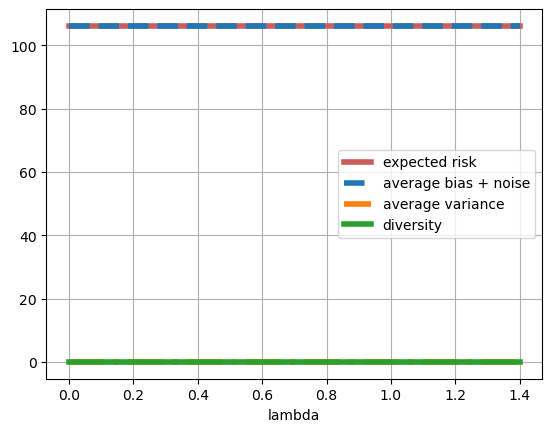

In [ ]:
from decompose.plotting_utils import plot_bvd
print(len(results))
results_idx = 25

ax = plot_bvd(results[results_idx])
# print(results[results_idx].diversity)
# print(results[results_idx].average_variance)
# ax.set_xlim(0,0.4)results[results_idx]